## NOTES TO SELF:

- Should have a discussion about the difficulty of handling unseen words in
  novel situations. Find research papers discussing this.

## Resources
- [Medium Article](https://towardsdatascience.com/word2vec-with-pytorch-implementing-original-paper-2cd7040120b0)
- [Github Project](https://github.com/OlgaChernytska/word2vec-pytorch)
- [Visualizing Word Embeddings](https://towardsdatascience.com/visualization-of-word-embedding-vectors-using-gensim-and-pca-8f592a5d3354)



## OUTLINE OF FINAL DOC:

- Introduction
- Data
- Data Preparation
- Building the Network
  - Architecture & Hyperparameters
- Validating the Performance
- References

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

from collections import Counter
from functools import partial
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import DataLoader
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator


In [2]:
# NOTE: If running this locally in an environment that has not yet setup nltk,
# need to run this code here.
# import nltk
# nltk.download('punkt')
# nltk.download('stopwords')

In [3]:

# Step 0: How big is this dataset? How big is this corpus?

data = pd.read_csv('./wiki_movie_plots_deduped.csv')

data.shape, data.columns

((34886, 8),
 Index(['Release Year', 'Title', 'Origin/Ethnicity', 'Director', 'Cast',
        'Genre', 'Wiki Page', 'Plot'],
       dtype='object'))

## PyTorch Pre-Processor / Tokenizer

In [4]:
train_mask = np.random.rand(len(data)) < 0.8
train_data = data[train_mask]["Plot"]
val_data = data[~train_mask]["Plot"]


In [5]:
CBOW_N_WORDS = 4
MAX_SEQUENCE_LENGTH = 256

def collate_cbow(batch, text_pipeline):
    batch_input = []
    batch_output = []

    for text in batch:
        text_tokens_ids = text_pipeline(text)

        if len(text_tokens_ids) < CBOW_N_WORDS * 2 + 1:
            continue

        if MAX_SEQUENCE_LENGTH:
            text_tokens_ids = text_tokens_ids[:MAX_SEQUENCE_LENGTH]

        for idx in range(len(text_tokens_ids) - CBOW_N_WORDS * 2):
            token_id_sequence = text_tokens_ids[idx : (idx + CBOW_N_WORDS * 2 + 1)]
            # Pop the word in the middle of the sequence.
            output = token_id_sequence.pop(CBOW_N_WORDS)
            input_ = token_id_sequence
            batch_input.append(input_)
            batch_output.append(output)

    batch_input = torch.tensor(batch_input, dtype=torch.long)
    batch_output = torch.tensor(batch_output, dtype=torch.long)

    return batch_input, batch_output



In [6]:
def build_dataloader(data_iter, batch_size, vocab = None):
    MIN_WORD_FREQUENCY=10

    tokenizer = get_tokenizer("basic_english", language="en")

    token_lists = map(tokenizer, data_iter)
    word_counts = Counter()

    if vocab is None:
        vocab = build_vocab_from_iterator(
            map(tokenizer, data_iter),
            specials=["<unk>"],
            min_freq=MIN_WORD_FREQUENCY
        )

        vocab.set_default_index(vocab["<unk>"])

    for tokens in token_lists:
        for token in tokens:
            word_counts[token] += 1

    def text_pipeline(x):
        return vocab(tokenizer(x))

    dataloader = DataLoader(
        data_iter,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=partial(collate_cbow, text_pipeline=text_pipeline)
    )

    return dataloader, word_counts, vocab



In [7]:

EMBED_MAX_NORM = 1

class CBOWModel(nn.Module):
    def __init__(self, vocab_size: int, embedding_dim: int):
        super(CBOWModel, self).__init__()

        self.embeddings = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embedding_dim,
            max_norm=EMBED_MAX_NORM
        )

        self.linear = nn.Linear(
            in_features=embedding_dim,
            out_features=vocab_size
        )


    def forward(self, inputs_):
        x = self.embeddings(inputs_)
        x = x.mean(axis=1)
        x = self.linear(x)
        return x



In [8]:
BATCH_SIZE=50

train_dataloader, train_word_counts, vocab = build_dataloader(
    data_iter=train_data.values,
    batch_size=BATCH_SIZE
)

val_dataloader, val_word_counts, _ = build_dataloader(
    data_iter=val_data.values,
    batch_size=BATCH_SIZE,
    vocab=vocab
)


In [25]:

# Code taken from here:
# https://github.com/OlgaChernytska/word2vec-pytorch/blob/main/utils/trainer.py

class Trainer:
    def __init__(
        self,
        model,
        epochs,
        train_dataloader,
        train_steps,
        val_dataloader,
        val_steps,
        criterion,
        optimizer,
        lr_scheduler
    ):
        self.model = model
        self.epochs = epochs
        self.train_dataloader = train_dataloader
        self.train_steps = train_steps
        self.val_dataloader = val_dataloader
        self.val_steps = val_steps
        self.criterion = criterion
        self.optimizer = optimizer
        self.lr_scheduler = lr_scheduler

        self.loss = {"train": [], "val": []}


    def train(self):
        for epoch in range(self.epochs):
            self._train_epoch()
            self._validate_epoch()

            print(
                "Epoch: {}/{}, Train Loss={:.5f}, Val Loss={:.5f}".format(
                    epoch + 1,
                    self.epochs,
                    self.loss["train"][-1],
                    self.loss["val"][-1]
                )
            )

            if self.lr_scheduler is not None:
                self.lr_scheduler.step()

    
    def _train_epoch(self):
        self.model.train()

        running_loss = []

        for i, batch_data in enumerate(self.train_dataloader, 1):
            inputs = batch_data[0]
            labels = batch_data[1]

            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()

            running_loss.append(loss.item())

            if i == self.train_steps:
                break

        epoch_loss = np.mean(running_loss)
        self.loss["train"].append(epoch_loss)

    def _validate_epoch(self):
        self.model.eval()
        running_loss = []

        with torch.no_grad():
            for i, batch_data in enumerate(self.val_dataloader, 1):
                inputs = batch_data[0]
                labels = batch_data[1]

                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)

                running_loss.append(loss.item())

                if i == self.val_steps:
                    break

        epoch_loss = np.mean(running_loss)
        self.loss["val"].append(epoch_loss)
        

In [26]:
MODEL_PATH = os.path.join('outputs', 'model.pt')
LOSS_PATH = os.path.join('outputs', 'loss.json')

def save_model(model):
    torch.save(model, MODEL_PATH)


def load_model():
    return torch.load(MODEL_PATH)


def save_loss(loss):
    with open(LOSS_PATH, 'w') as fp:
        json.dump(loss, fp)


def load_loss():
    with open(LOSS_PATH) as fp:
        loss = json.load(fp)

    return loss


In [ ]:
EPOCHS=50
LR=0.05

model = CBOWModel(vocab_size=len(vocab), embedding_dim=300)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

lr_lambda = lambda epoch: (EPOCHS - epoch) / EPOCHS
lr_scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda, verbose=True)

trainer = Trainer(
    model=model,
    epochs=EPOCHS,
    train_dataloader=train_dataloader,
    train_steps=10,
    val_dataloader=val_dataloader,
    val_steps=10,
    criterion=criterion,
    optimizer=optimizer,
    lr_scheduler=lr_scheduler
)

trainer.train()
loss = trainer.loss
print("Training finished")

save_model(model)
save_loss(trainer.loss)
print("Data Saved")

    

Adjusting learning rate of group 0 to 5.0000e-02.
Epoch: 1/50, Train Loss=8.43933, Val Loss=7.09865
Adjusting learning rate of group 0 to 4.9000e-02.
Epoch: 2/50, Train Loss=7.00528, Val Loss=6.80250
Adjusting learning rate of group 0 to 4.8000e-02.
Epoch: 3/50, Train Loss=6.79649, Val Loss=6.68841
Adjusting learning rate of group 0 to 4.7000e-02.
Epoch: 4/50, Train Loss=6.67614, Val Loss=6.54879
Adjusting learning rate of group 0 to 4.6000e-02.
Epoch: 5/50, Train Loss=6.63726, Val Loss=6.50792
Adjusting learning rate of group 0 to 4.5000e-02.
Epoch: 6/50, Train Loss=6.53190, Val Loss=6.45505
Adjusting learning rate of group 0 to 4.4000e-02.
Epoch: 7/50, Train Loss=6.50351, Val Loss=6.38956
Adjusting learning rate of group 0 to 4.3000e-02.
Epoch: 8/50, Train Loss=6.40854, Val Loss=6.34789
Adjusting learning rate of group 0 to 4.2000e-02.
Epoch: 9/50, Train Loss=6.38465, Val Loss=6.34859
Adjusting learning rate of group 0 to 4.1000e-02.
Epoch: 10/50, Train Loss=6.38135, Val Loss=6.32062

In [24]:
model = load_model()
loss = load_loss()

# Verify that the model loaded is compatible with the current vocabulary.
# len(vocab)
assert len(vocab) == model.embeddings.num_embeddings, "Vocab is incompatible with the model being loaded."


AssertionError: Vocab is incompatible with the model being loaded.

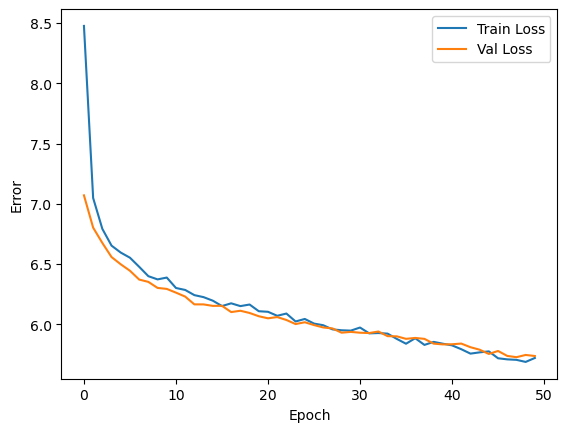

In [12]:
plt.plot(loss['train'], label='Train Loss')
plt.plot(loss['val'], label='Val Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.show()

In [ ]:
[x for x in itertools.islice(train_word_counts.most_common(), 10)]
stops
punc = set([',', '\'', '.', '-', '!', '?', '-', '(', ')'])

COUNT = 20
most_common = []

for word, count in train_word_counts.most_common():
    if word in stops or word in punc:
        continue
    
    most_common.append((word, count))

    if len(most_common) >= COUNT:
        break

most_common


In [13]:

def k_nearest_words(model, vocab, word, k):
    word_index = vocab([word])[0]
    num_embeddings = model.embeddings.num_embeddings
    word_embedding = model.embeddings(torch.Tensor([word_index]).type(torch.long))

    k_closest_indices = []
    k_closest_norms = []

    for index in range(num_embeddings):
        if index == word_index:
            continue

        compare_embedding = model.embeddings(torch.Tensor([index]).type(torch.long))
        diff = compare_embedding - word_embedding
        norm = torch.linalg.norm(diff).item()

        if len(k_closest_indices) < k:
            k_closest_indices.append(index)
            k_closest_norms.append(norm)
        else:
            for i in range(k):
                if norm < k_closest_norms[i]:
                    k_closest_indices[i] = index
                    k_closest_norms[i] = norm
                    break

    return [vocab.lookup_token(index) for index in k_closest_indices]

    

In [14]:
for word in most_common:
    nearest = k_nearest_words(model, vocab, word, 5)
    print(f'{word} -> {nearest}')


['family', 'girl', 'war', 'filkins', 'based']

In [15]:
# PCA 2D
# Taken from here:
# https://towardsdatascience.com/visualization-of-word-embedding-vectors-using-gensim-and-pca-8f592a5d3354

embeddings_np = model.embeddings.weight.detach().numpy()
df = pd.DataFrame(embeddings_np, index=vocab.get_itos())

X_corr = df.corr()
values, vectors = np.linalg.eig(X_corr)
args = (-values).argsort()
values = vectors[args]
vectors = vectors[:, args]

# Taking first 2 components which explain maximum variance for projecting.
new_vectors = vectors[:, :2]

# Projecting it onto new dimension with 2 axis
neww_X = np.dot(embeddings_np, new_vectors)
neww_X


ValueError: Shape of passed values is (36274, 300), indices imply (36214, 300)

In [182]:
# Taken from here:
# https://towardsdatascience.com/visualization-of-word-embedding-vectors-using-gensim-and-pca-8f592a5d3354

def plot_words(words):
    stoi = vocab.get_stoi()
    indices = [stoi[w] for w in words]

    plt.figure(figsize=(13, 7))
    plt.scatter(neww_X[indices, 0], neww_X[indices, 1], linewidths=10, color='lightgray')
    plt.xlabel("PC1", size=15)
    plt.ylabel("PC2", size=15)
    plt.title("Word Embedding Space", size=20)

    for i, word in enumerate(words):
        plt.annotate(word, xy=(neww_X[indices[i], 0], neww_X[indices[i], 1]))
    
    plt.show()


In [177]:
[vocab.get_stoi()[w] for w in ['hello', 'world']]

[14686, 220]